In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import mnist
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(42)

In [ ]:
# dataloading from MNIST
dataloader = DataLoader(
    mnist.MNIST('.',download=True,transform=transforms.ToTensor()),
    batch_size=128,
    shuffle=True
)

def tensor_to_images(image_tensor, num_images=30, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=6)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.83MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.61MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



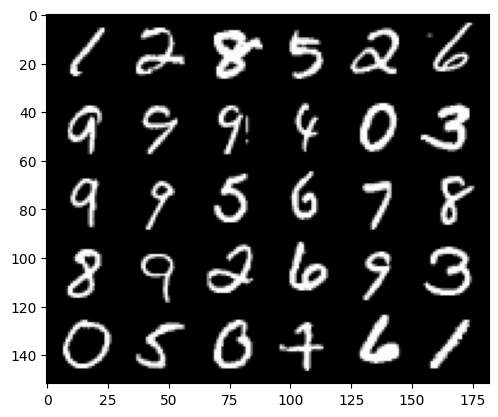

In [ ]:
sample_img = next(iter(dataloader))[0]
tensor_to_images(sample_img)

In [ ]:
# generator model
class Generator(nn.Module):
    def __init__(self, noise_dim=10, img_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.img_dim = img_dim
        self.hidden_dim = hidden_dim

        self.gen = nn.Sequential(
            self.gen_block(self.noise_dim, self.hidden_dim),
            self.gen_block(self.hidden_dim, self.hidden_dim * 2),
            self.gen_block(self.hidden_dim * 2, self.hidden_dim * 4),
            self.gen_block(self.hidden_dim * 4, self.hidden_dim * 8),
            nn.Linear(self.hidden_dim * 8, self.img_dim), # Changed h_dim to hidden_dim and im_dim to img_dim
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    def gen_block(self, input_dim, output_dim):
        # gen block with
        # linear layer
        # batch normalization
        # relu activation function
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True)
        )

In [ ]:
# discriminator model
# input image of dimension 784
# hidden of 128

# with block od linear anf=d leakyrelu

class Discriminator(nn.Module):
  def __init__(self, img_dim = 784, hidden_dim = 128):
    super(Discriminator, self).__init__()
    self.img_dim = img_dim
    self.hidden_dim = hidden_dim

    self.disc = nn.Sequential(
        self.disc_block(self.img_dim, self.hidden_dim*8),
        self.disc_block(self.hidden_dim*8, self.hidden_dim*4),
        self.disc_block(self.hidden_dim*4, self.hidden_dim*2),
        self.disc_block(self.hidden_dim*2, self.hidden_dim),
        nn.Linear(self.hidden_dim, 1)
    )

  def forward(self, image):
    return self.disc(image)

  def disc_block(self, input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [ ]:
# generation of noise

def get_noise(n_samples, noise_vector_dim, device='cpu'):
  return torch.randn(n_samples, noise_vector_dim, device=device)

In [ ]:
# training hyper parameter

n_epochs = 200
noise_dimension = 64
batch_size =128
lr = 0.00001
display_step = 500


criterion = nn.BCEWithLogitsLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Generator & Optimizer for Generator
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# Discriminator & Optimizer for Discriminator
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
# loss function

def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):

  # generate the noise
  noise = get_noise(num_images, noise_dimension, device=device)
  fake = gen(noise)

  # disc prediction on fake generated by generator
  disc_fake_preds = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_preds, torch.zeros_like(disc_fake_preds))

  # disc prediction on real images
  disc_real_preds = disc(real)
  disc_real_loss = criterion(disc_real_preds, torch.ones_like(disc_real_preds))

  disc_loss = (disc_fake_loss + disc_real_loss) / 2

  return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):

  # generate the noise
  noise = get_noise(num_images, noise_dimension, device=device)
  fake = gen(noise)

  disc_fake_preds = disc(fake)
  gen_loss = criterion(disc_fake_preds, torch.ones_like(disc_fake_preds))

  return gen_loss


In [ ]:
# Training loop

cur_step = 0
mean_gen_loss = 0
mean_disc_loss = 0
gen_loss = False

for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):

    cur_batch_size = len(real)
    real = real.view(cur_batch_size, -1).to(device)

    # Training the discriminator

    disc_opt.zero_grad()
    disc_loss = get_disc_loss(gen,disc,criterion,real,cur_batch_size,noise_dimension,device)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    # Training the generator

    gen_opt.zero_grad()
    gen_loss = get_gen_loss(gen,disc,criterion,cur_batch_size,noise_dimension,device)
    gen_loss.backward()
    gen_opt.step()

    mean_disc_loss += disc_loss.item() / display_step
    mean_gen_loss += gen_loss.item() / display_step

    if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_gen_loss}, discriminator loss: {mean_disc_loss}")
            fake_noise = get_noise(cur_batch_size, noise_dimension, device=device)
            fake = gen(fake_noise)
            tensor_to_images(fake)
            tensor_to_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0

    cur_step += 1



Output hidden; open in https://colab.research.google.com to view.